In [1]:
import os
import json
import functools

import numpy
import matplotlib
from matplotlib import pyplot

from discohisto import (
    fit_normal,
    fit_cabinetry,
    fit_cabinetry_post,
    fit_linspace,
    fit_mcmc_mix,
    fit_mcmc_tfp_ham,
    region,
    limit,
    stats,
)

In [2]:
SEARCHES_PATH = "searches/"

In [3]:
@functools.cache
def load_searches():
    searches = []
    for item in os.scandir(SEARCHES_PATH):
        if not item.is_dir():
            continue
        searches.append(item.name)
        
    return sorted(searches)


def load_reported(search):
    path = os.path.join(SEARCHES_PATH, search, "reported.json")
    with open(path) as file_:
        reported = json.load(file_)
    return reported


def _get_n_region(reg):
    sr_name = reg.signal_region_name
    observations = reg.workspace

    for obs in reg.workspace["observations"]:
        if obs["name"] == sr_name:
            return obs["data"][0]

    raise ValueError(sr_name)


def _load_mcmc_limits(path, *, suffix):
    mcmc_types = ["mix", "tfp_ham"]
    lim = None
    for mcmc_type in mcmc_types:
        suffix_i = "_mcmc_%s_%s" % (mcmc_type, suffix)
        try:
            lim = limit.LimitScan.load(path, suffix=suffix_i)
        except FileNotFoundError:
            ...
    assert lim is not None
    return lim


def _load_limit(limit_dir, suffix):
    lim = limit.LimitScan.load(limit_dir, suffix=suffix)
    assert lim.levels[6:8] == [-2, -3], lim.levels[6:8]
    return lim


def _limit_logl(lim):
    return numpy.log(numpy.mean(lim.integral_zero))

In [4]:
def load_frame():
    searches = load_searches()
    
    # frame entries
    search_ = []
    region_ = []
    reported_n = []
    reported_bkg = []
    reported_bkg_hi = []
    reported_bkg_lo = []
    reported_s95obs = []
    reported_s95exp = []
    reported_s95exp_hi = []
    reported_s95exp_lo = []
    
    region_n = []
    
    fit_cabinetry_bkg = []
    fit_cabinetry_err = []
    fit_cabinetry_post_bkg = []
    fit_cabinetry_post_err = []
    
    limit_cabinetry_obs_2 = []
    limit_cabinetry_obs_3 = []
    limit_cabinetry_log_like = []
    
    limit_cabinetry_post_obs_2 = []
    limit_cabinetry_post_obs_3 = []
    
    limit_normal_obs_2 = []
    limit_normal_obs_3 = []
    limit_normal_log_like = []
    
    limit_normal_log_obs_2 = []
    limit_normal_log_obs_3 = []
    limit_normal_log_log_like = []
    
    limit_delta_obs_2 = []
    limit_delta_obs_3 = []
    limit_delta_log_like = []
    
    limit_linspace_obs_2 = []
    limit_linspace_obs_3 = []
    limit_linspace_log_like = []
    
    limit_mcmc_obs_2 = []
    limit_mcmc_obs_3 = []
    limit_mcmc_log_like = []
    
    for search in searches:
        reported = load_reported(search)
        for region_name in reported:
            search_.append(search)
            region_.append(region_name)
            
            # reported
            reported_reg = reported[region_name]
            
            n_observed = reported_reg["n"]
            reported_n.append(n_observed)
            reported_bkg.append(reported_reg["bkg"])
            reported_bkg_hi.append(reported_reg["bkg_hi"])
            reported_bkg_lo.append(reported_reg["bkg_lo"])
            reported_s95obs.append(reported_reg["s95obs"])
            reported_s95exp.append(reported_reg["s95exp"])
            reported_s95exp_hi.append(reported_reg["s95exp_hi"])
            reported_s95exp_lo.append(reported_reg["s95exp_lo"])
            
            # region
            region_dir = os.path.join(SEARCHES_PATH, search, region_name)
            region_i = region.Region.load(region_dir)
            region_n.append(_get_n_region(region_i))
            
            # standard fits
            fit_dir = os.path.join(region_dir, "fit")
            
            fit = fit_cabinetry.FitCabinetry.load(fit_dir)
            fit_cabinetry_bkg.append(fit.yield_pre)
            fit_cabinetry_err.append(fit.error_pre)
            
            fit = fit_cabinetry_post.FitCabinetryPost.load(fit_dir)
            fit_cabinetry_post_bkg.append(fit.yield_post)
            fit_cabinetry_post_err.append(fit.error_post)
            
            fit = fit_normal.FitNormal.load(fit_dir)
            mu_delta = fit.yield_linear
            
            # limits
            limit_dir = os.path.join(fit_dir, "limit")
            load_limit = functools.partial(_load_limit, limit_dir)
            
            lim = load_limit("_cabinetry_observed")
            limit_cabinetry_obs_2.append(lim.points[6][-1])
            limit_cabinetry_obs_3.append(lim.points[7][-1])
            limit_cabinetry_log_like.append(_limit_logl(lim))
            
            lim = load_limit("_cabinetry_post_observed")
            limit_cabinetry_post_obs_2.append(lim.points[6][-1])
            limit_cabinetry_post_obs_3.append(lim.points[7][-1])
            
            lim = load_limit("_linspace_observed")
            limit_linspace_obs_2.append(lim.points[6][-1])
            limit_linspace_obs_3.append(lim.points[7][-1])
            limit_linspace_log_like.append(_limit_logl(lim))
            
            lim = load_limit("_normal_observed")
            limit_normal_obs_2.append(lim.points[6][-1])
            limit_normal_obs_3.append(lim.points[7][-1])
            limit_normal_log_like.append(_limit_logl(lim))
            
            lim = load_limit("_normal_log_observed")
            limit_normal_log_obs_2.append(lim.points[6][-1])
            limit_normal_log_obs_3.append(lim.points[7][-1])
            limit_normal_log_log_like.append(_limit_logl(lim))
                        
            lim = limit.LimitScanDelta.load(limit_dir, suffix="_observed")
            assert lim.levels[6:8] == [-2, -3], lim.levels[6:8]
            limit_delta_obs_2.append(lim.points[6][-1])
            limit_delta_obs_3.append(lim.points[7][-1])
            limit_delta_log_like.append(stats.poisson_log_minus_max(n_observed, mu_delta))
            
            lim = _load_mcmc_limits(limit_dir, suffix="observed")
            assert lim.levels[6:8] == [-2, -3], lim.levels[6:8]
            limit_mcmc_obs_2.append(lim.points[6][-1])
            limit_mcmc_obs_3.append(lim.points[7][-1])
            limit_mcmc_log_like.append(_limit_logl(lim))

    out = dict(
        # labels
        search_=search_,
        region_=region_,
        # reported
        reported_n=reported_n,
        reported_bkg=reported_bkg,
        reported_bkg_hi=reported_bkg_hi,
        reported_bkg_lo=reported_bkg_lo,
        reported_s95obs=reported_s95obs,
        reported_s95exp=reported_s95exp,
        reported_s95exp_hi=reported_s95exp_hi,
        reported_s95exp_lo=reported_s95exp_lo,
        region_n=region_n,
        # fits
        fit_cabinetry_bkg=fit_cabinetry_bkg,
        fit_cabinetry_err=fit_cabinetry_err,
        fit_cabinetry_post_bkg=fit_cabinetry_post_bkg,
        fit_cabinetry_post_err=fit_cabinetry_post_err,
        # limits
        limit_cabinetry_obs_2=limit_cabinetry_obs_2,
        limit_cabinetry_obs_3=limit_cabinetry_obs_3,
        limit_cabinetry_log_like=limit_cabinetry_log_like,
        limit_cabinetry_post_obs_2=limit_cabinetry_post_obs_2,
        limit_cabinetry_post_obs_3=limit_cabinetry_post_obs_3,
        limit_normal_obs_2=limit_normal_obs_2,
        limit_normal_obs_3=limit_normal_obs_3,
        limit_normal_log_like=limit_normal_log_like,
        limit_normal_log_obs_2=limit_normal_log_obs_2,
        limit_normal_log_obs_3=limit_normal_log_obs_3,
        limit_normal_log_log_like=limit_normal_log_log_like,
        limit_delta_obs_2=limit_delta_obs_2,
        limit_delta_obs_3=limit_delta_obs_3,
        limit_delta_log_like=limit_delta_log_like,
        limit_linspace_obs_2=limit_linspace_obs_2,
        limit_linspace_obs_3=limit_linspace_obs_3,
        limit_linspace_log_like=limit_linspace_log_like,
        limit_mcmc_obs_2=limit_mcmc_obs_2,
        limit_mcmc_obs_3=limit_mcmc_obs_3,
        limit_mcmc_log_like=limit_mcmc_log_like,
    )
    
    return {key: numpy.array(value) for key, value in out.items()}
        

FRAME = load_frame()

In [5]:
print(numpy.array_equal(FRAME["reported_n"], FRAME["region_n"]))

True


In [6]:
print(load_searches())

['atlas_susy_1Lbb_2020', 'atlas_susy_1Ljets_2021', 'atlas_susy_2L0J_2019', 'atlas_susy_2Ljets_2022', 'atlas_susy_2hadtau_2020', 'atlas_susy_3LRJmimic_2020', 'atlas_susy_3L_2021', 'atlas_susy_3Lresonance_2020', 'atlas_susy_3Lss_2019', 'atlas_susy_4L_2021', 'atlas_susy_DVmuon_2020', 'atlas_susy_compressed_2020', 'atlas_susy_hb_2019', 'atlas_susy_jets_2021']


In [7]:
def print_mean_log_likes():
    name_to_mean_log_like = {
        "cabinetry": numpy.mean(FRAME["limit_cabinetry_log_like"]),
        "normal": numpy.mean(FRAME["limit_normal_log_like"]),
        "normal_log": numpy.mean(FRAME["limit_normal_log_log_like"]),
        "delta": numpy.mean(FRAME["limit_delta_log_like"]),
        "linspace": numpy.mean(FRAME["limit_linspace_log_like"]),
        "mcmc": numpy.mean(FRAME["limit_mcmc_log_like"]),
    }
    
    ref = max(name_to_mean_log_like.values())
    
    for name, q in name_to_mean_log_like.items():
        print("%15s %6.3f %6.3f" % (name, q, q - ref))


print_mean_log_likes()    

      cabinetry -0.632  0.000
         normal -0.633 -0.001
     normal_log -0.632 -0.001
          delta -0.692 -0.060
       linspace -0.675 -0.043
           mcmc -0.822 -0.190


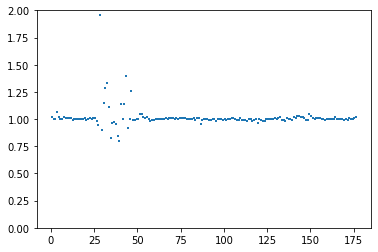

In [8]:
def plot_bkgs():
    repored_bkg = numpy.array(FRAME["reported_bkg"])
    fit_cabinetry_bkg = numpy.array(FRAME["fit_cabinetry_bkg"])

    y = fit_cabinetry_bkg / repored_bkg
    x = numpy.arange(len(y)) + 0.5
    
    pyplot.scatter(x, y, lw=0, s=2, marker=",")
    
    pyplot.ylim(0, 2)
    pyplot.show()
    
plot_bkgs()

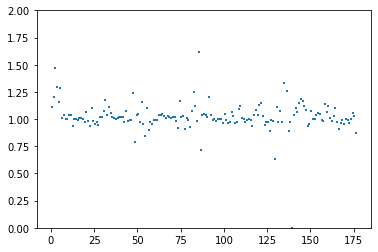

In [9]:
def plot_bkgs_post():
    repored_bkg = numpy.array(FRAME["reported_bkg"])
    fit_cabinetry_bkg = numpy.array(FRAME["fit_cabinetry_post_bkg"])

    y = fit_cabinetry_bkg / repored_bkg
    x = numpy.arange(len(y)) + 0.5
    
    pyplot.scatter(x, y, lw=0, s=2, marker=",")
    
    pyplot.ylim(0, 2)
    pyplot.show()
    
plot_bkgs_post()

In [10]:
def plot_limits(label):
    repored_obs = numpy.array(FRAME["reported_s95obs"])
    cabinetry_obs_2 = numpy.array(FRAME["limit_%s_obs_2" % label])
    cabinetry_obs_3 = numpy.array(FRAME["limit_%s_obs_3" % label])

    y2 = cabinetry_obs_2
    y3 = cabinetry_obs_3
    x = repored_obs
    
    pyplot.scatter(x, y2, color="r", lw=0, s=2, marker=",")
    pyplot.scatter(x, y3, color="b", lw=0, s=2, marker=",")
    pyplot.plot([0, 200], [0, 200], "k", alpha=0.2)
    
    pyplot.yscale("log")
    pyplot.xscale("log")
    pyplot.axis("equal")
    
    pyplot.show()


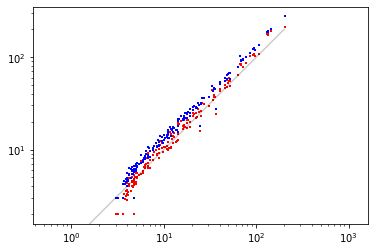

In [11]:
plot_limits("cabinetry")

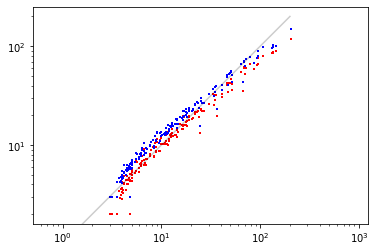

In [12]:
plot_limits("cabinetry_post")

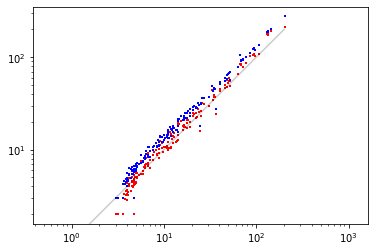

In [13]:
plot_limits("normal")

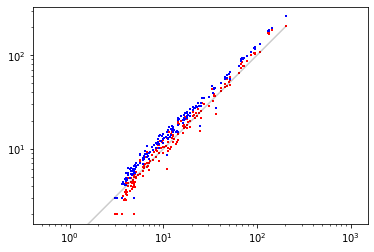

In [14]:
plot_limits("normal_log")

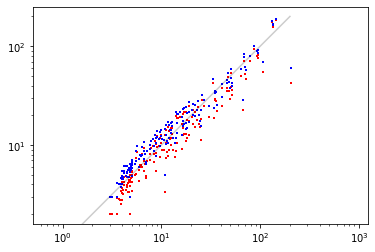

In [15]:
plot_limits("delta")

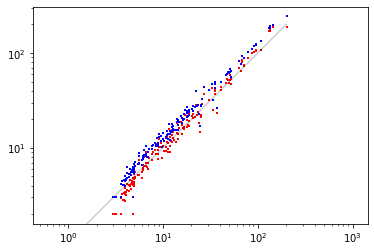

In [16]:
plot_limits("linspace")

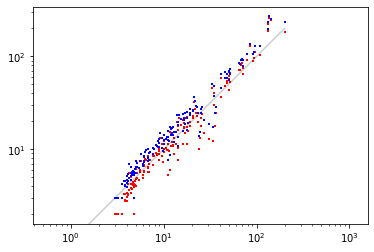

In [17]:
plot_limits("mcmc")

In [18]:
# TODO inspect anomalies
# TODO add quantiles as error bars

In [19]:
2 / numpy.log(2), numpy.exp(2)

(2.8853900817779268, 7.38905609893065)

In [20]:
3 / numpy.log(2), numpy.exp(3)

(4.328085122666891, 20.085536923187668)